In [69]:
%load_ext autoreload
%autoreload 2
filename = "use-local-updates_true-GAS-1.csv"
import seaborn as sns
sns.set_style("darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import json
import wandb
from dotenv import load_dotenv
load_dotenv(override=True)
api = wandb.Api(timeout=30)

# Project is specified by <entity/project-name>
runs = api.runs("kubework/hivemind-parameter-averaging-resnet18-imagenet_scale-up", filters={
    "$and": [
        {"config.run_name": {"$regex": "hivemind-*"}},
        {"summary_metrics.cpu/logical_core_count": 8},
        {"config.batch_size_per_step": {"$in": [32, 64, 128]}},
        {"config.use_local_updates": True},
        {"config.target_batch_size": {"$lte": 10000}},
        {"config.number_of_nodes": 2},
        {"config.gradient_accumulation_steps": 1},
    ]
})
history_list = []
summary_list = []
config_list = []

for run in runs:
    summary_list.append(run.summary._json_dict)
    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items()}
    config["optimizer_params.lr"] = config["optimizer_params"]["lr"]
    config["optimizer_params.momentum"] = config["optimizer_params"]["momentum"]
    config_list.append(config)

    history = run.scan_history(keys=[
        "_timestamp",
        "train/step",
        "bandwidth/net_recv_sys_bandwidth_mbs",
        "bandwidth/net_sent_sys_bandwidth_mbs",
        "train/samples_ps",
        "train/data_load_s",
        "train/model_forward_s",
        ("train/model_backward_only_s" if "train/model_backward_only_s" in run.summary._json_dict else "train/model_backward_s"),
        *(["train/model_opt_s"] if "train/model_backward_only_s" in run.summary._json_dict else []),
    ])
    history_tmp = []
    sum_total_time_s = 0
    sum_missing_time_s = 0
    for row in history:
        total_time_s = config["batch_size_per_step"] / row["train/samples_ps"]
        missing_time_s = total_time_s - row["train/data_load_s"] - row["train/model_forward_s"]
        # for old runs incorporating both...
        if "train/model_backward_only_s" in row:
            missing_time_s -= row["train/model_backward_only_s"] - row["train/model_opt_s"]
        else:
            missing_time_s -= row["train/model_backward_s"]
        sum_total_time_s += total_time_s
        sum_missing_time_s += missing_time_s
        history_tmp.append({**row, **config, "name": run.name, "train/total_time_s": total_time_s, "train/missing_time_s": missing_time_s})
    history_list.extend(history_tmp)
    summary_list.append({
        **run.summary._json_dict,
        "train/total_time_s": sum_total_time_s / len(history_tmp),
        "train/missing_time_s": sum_missing_time_s / len(history_tmp),
    })

import pandas as pd 
history_df = pd.DataFrame.from_records(history_list) 
all_df = pd.concat([history_df], axis=1)
all_df.to_csv(filename)

config_df = pd.DataFrame.from_records(config_list) 
summary_df = pd.DataFrame.from_records(summary_list)
all_df = pd.concat([config_df, summary_df], axis=1)
all_df.to_csv(f"summary-{filename}")

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


/home/adi/Workspace/TUM/TUMThesis/viz/venv/lib/python3.8/site-packages/seaborn/categorical.py:3197: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


<Figure size 640x480 with 0 Axes>

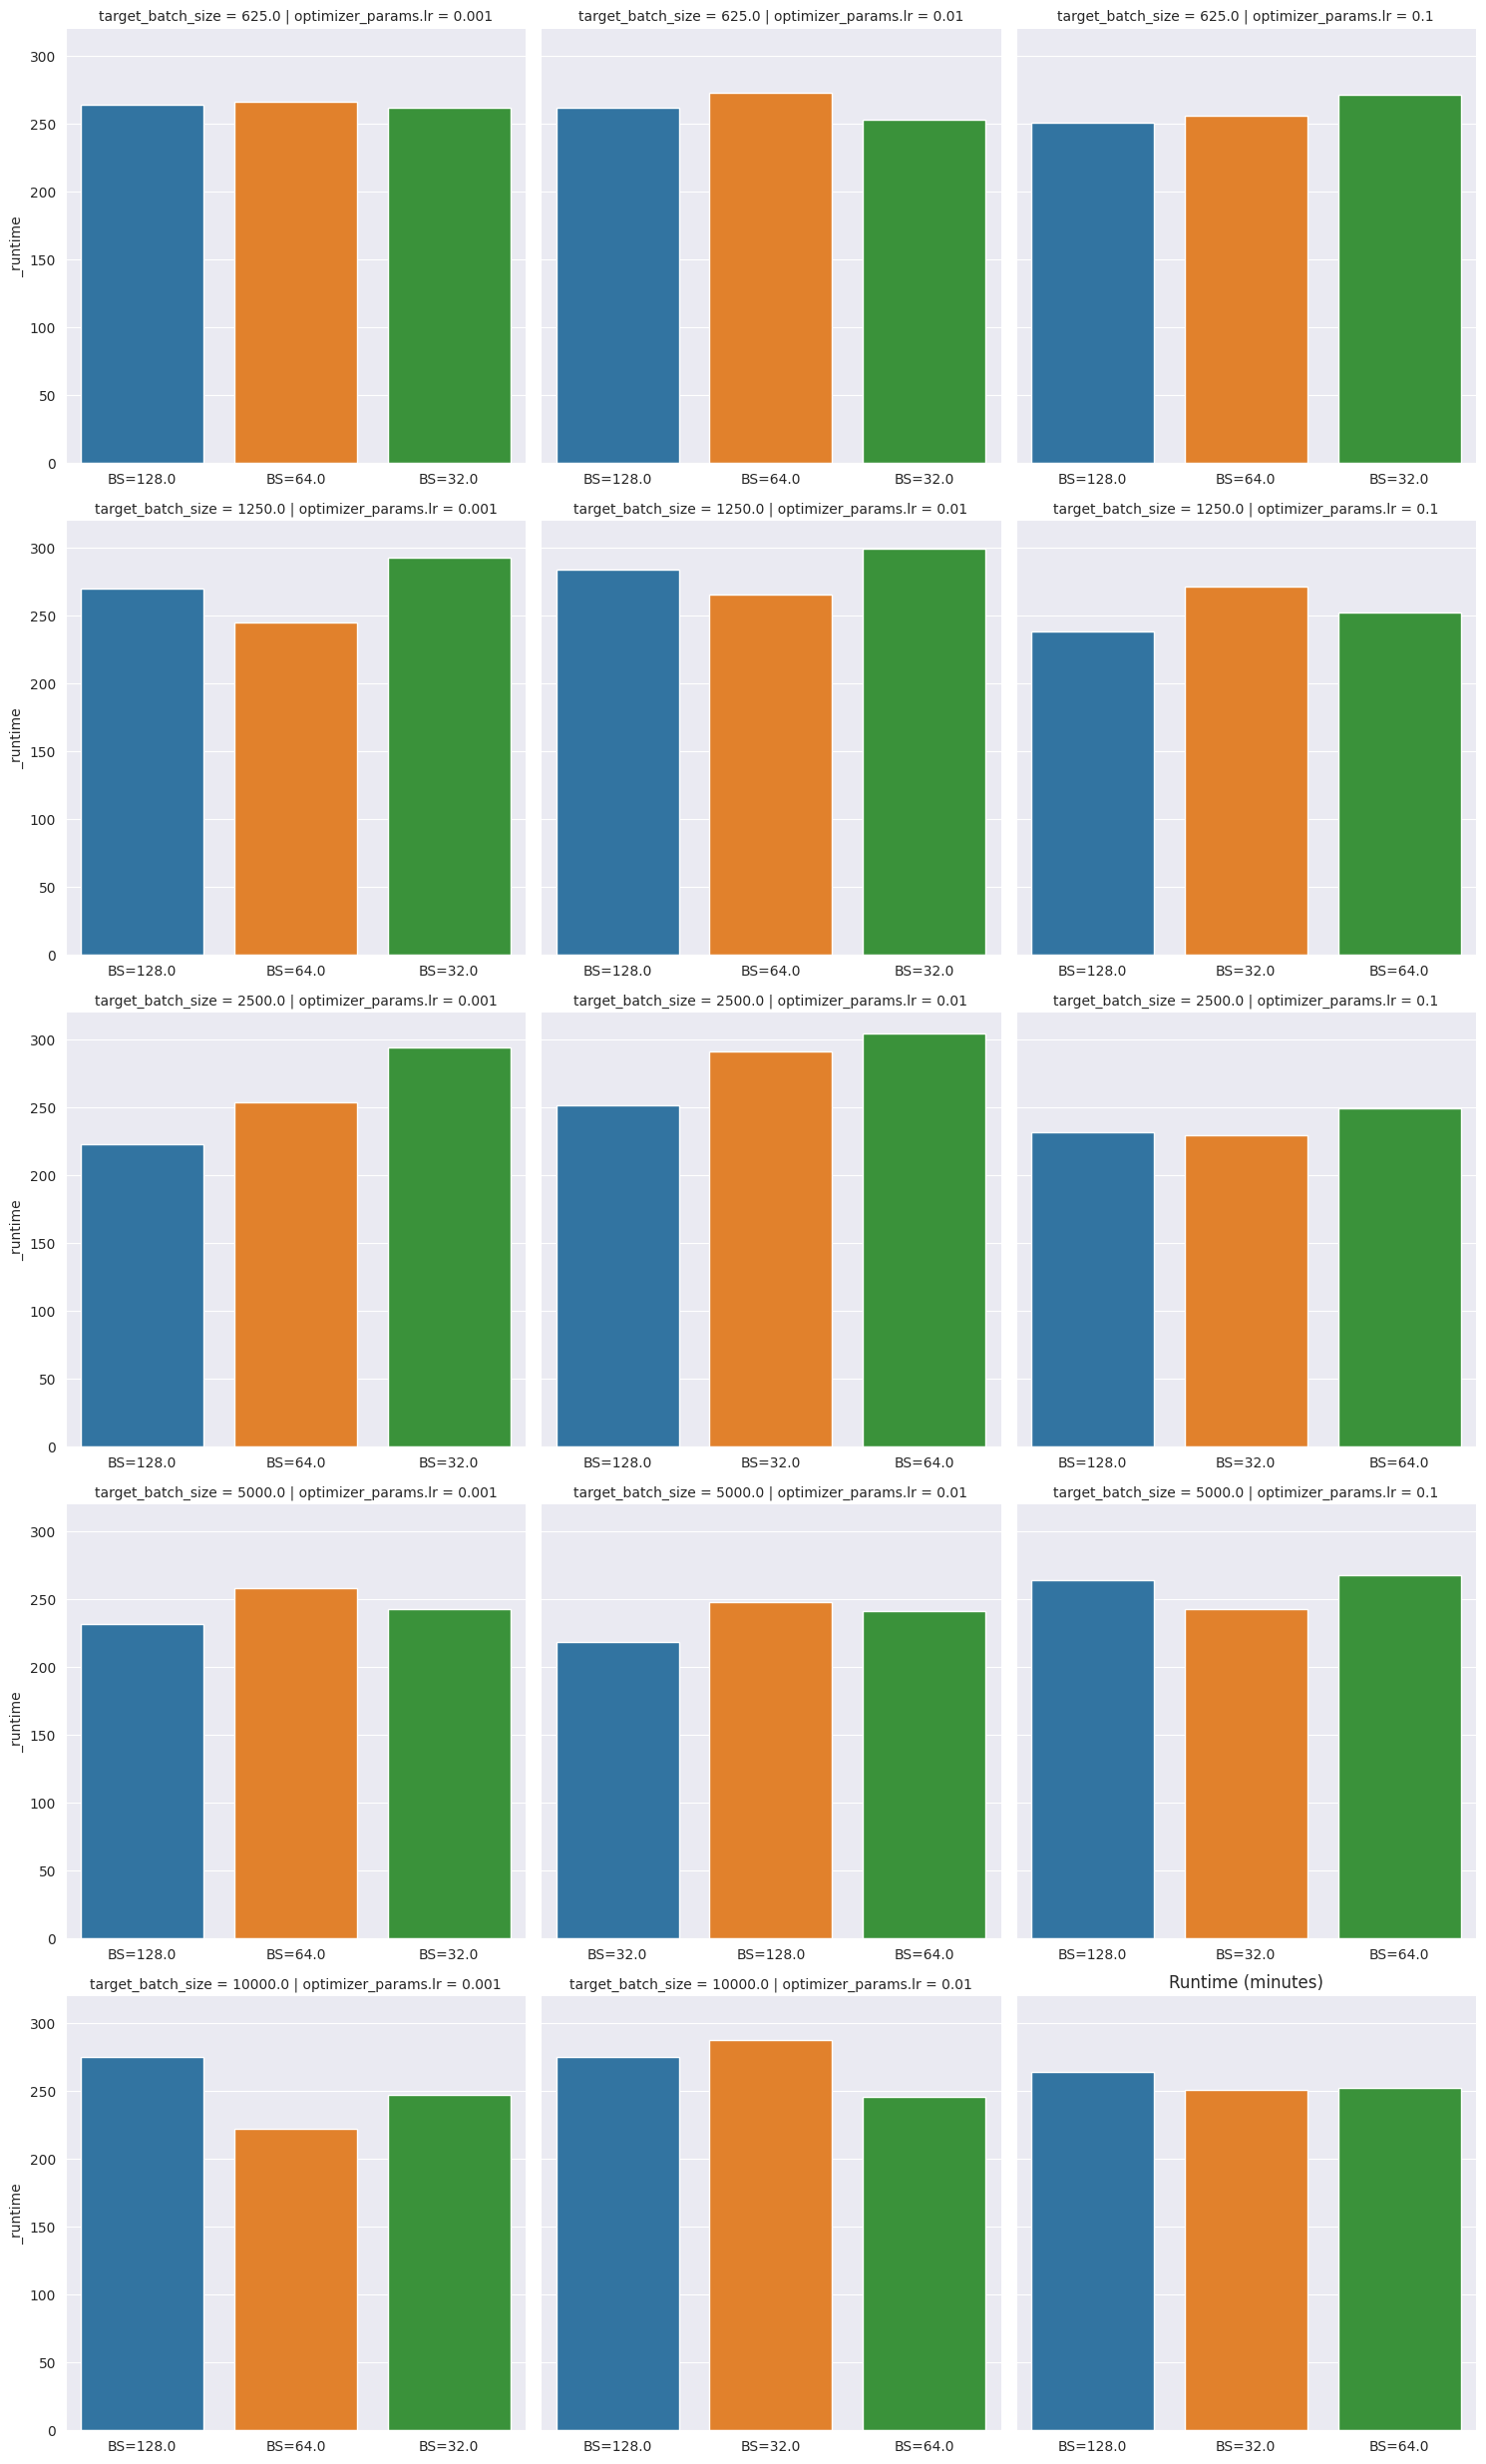

In [86]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")
data["_runtime"] = data["_runtime"] / 60
data["run_name"] = data.apply(lambda row: f"BS={row['batch_size_per_step']}", axis=1)

fig = plt.figure()

ax = sns.catplot(data, kind="bar", x='run_name', y='_runtime', col="optimizer_params.lr", row="target_batch_size", errorbar="sd", dodge=False, sharex=False)

plt.title("Runtime (minutes)")
ax.set_xlabels("")

fig = plt.gcf()
fig.savefig(f"../../figures/06_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
plt.show()

In [50]:
import ast
import os
import pandas as pd

baseline_data = pd.read_csv(os.path.abspath('') + f"/summary-baseline-16vCPUs-GAS-1.csv")
baseline_data["_runtime"] = baseline_data["_runtime"] / 60
baseline_data["train/loss"] = baseline_data["train/loss"].apply(lambda x: ast.literal_eval(x)["min"])

baseline_data = baseline_data.groupby(["optimizer_params.lr", "batch_size_per_step", "run_name", "gradient_accumulation_steps"]) \
    ["_runtime", "train/loss"].describe().reset_index()
baseline_data = baseline_data.sort_values(
    by=["optimizer_params.lr", "gradient_accumulation_steps"],
)

def find_baseline(baseline_data, batch_size, lr, gas):
    found_run = baseline_data[
        (baseline_data["batch_size_per_step"] == batch_size) &
        (baseline_data["optimizer_params.lr"] == lr) &
        (baseline_data["gradient_accumulation_steps"] == gas)
    ]

    assert len(found_run) == 1

    return found_run.iloc[0]


/tmp/ipykernel_439/495841409.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  baseline_data = baseline_data.groupby(["optimizer_params.lr", "batch_size_per_step", "run_name", "gradient_accumulation_steps"]) \


In [54]:
def calc_increase_info(current_value, to_compare_value, sign=1):
    runtime_increase = (current_value - to_compare_value) / to_compare_value * 100
    runtime_increase_sign = "+" if runtime_increase * sign > 0 else "-"
    runtime_increase_color = "red" if runtime_increase * sign > 0 else "ForestGreen"
    runtime_increase = abs(round(runtime_increase, 2))
    return runtime_increase, runtime_increase_sign, runtime_increase_color

def print_increase_info(current_value, to_compare_value):
    runtime_increase, runtime_increase_sign, runtime_increase_color = calc_increase_info(current_value, to_compare_value)
    return f"{current_value} ({runtime_increase_sign}\\textcolor{{{runtime_increase_color}}}{{{runtime_increase}\%}})"

In [55]:
import os
import json
import pandas as pd
import ast

data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")
data["_runtime"] = data["_runtime"] / 60
data["train/loss"] = data["train/loss"].apply(lambda x: ast.literal_eval(x)["min"])

to_keep = ["max_steps", "batch_size_per_step", "optimizer_params.lr", "target_batch_size", "gradient_accumulation_steps"]
data = data.groupby(to_keep)["_runtime", "train/loss"].describe().reset_index()
data = data.sort_values(
    to_keep,
    ascending=[False, True, True, False, True]
)
latex_output = []

last_batch_size = 0
for _, row in data.iterrows():
    max_steps = int(row['max_steps'])
    batch_size_per_step = int(row['batch_size_per_step'])
    lr = row['optimizer_params.lr'][0]
    target_batch_size = int(row['target_batch_size'])
    gas = int(row['gradient_accumulation_steps'])

    # grabbing max, as this is the actual end of the run
    runtime_max = round(row["_runtime"]['max'], 2)
    loss_min = round(row["train/loss"]["min"], 4)

    if batch_size_per_step != last_batch_size:
        latex_output.append(f"\\multicolumn{{7}}{{|c|}}{{Batch size {batch_size_per_step}}} \\\\")
        latex_output.append("\\hline")
        last_batch_size = batch_size_per_step

    baseline_run = find_baseline(baseline_data, batch_size_per_step, lr, gas)
    runtime_string = print_increase_info(runtime_max, baseline_run["_runtime"]["mean"])
    loss_string = print_increase_info(loss_min, baseline_run["train/loss"]["min"])

    latex_output.append(f"{max_steps} & {batch_size_per_step} & {lr} & {target_batch_size} & {gas} & {runtime_string} & {loss_string} \\\\")
    latex_output.append("\\hline")

latex_output = "\n".join(latex_output)
with open(f"../../figures/06_summary-{filename.replace('.csv', '.tex')}", "w+") as f:
    f.write(latex_output)


/tmp/ipykernel_439/2509758913.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data = data.groupby(to_keep)["_runtime", "train/loss"].describe().reset_index()


<Figure size 640x480 with 0 Axes>

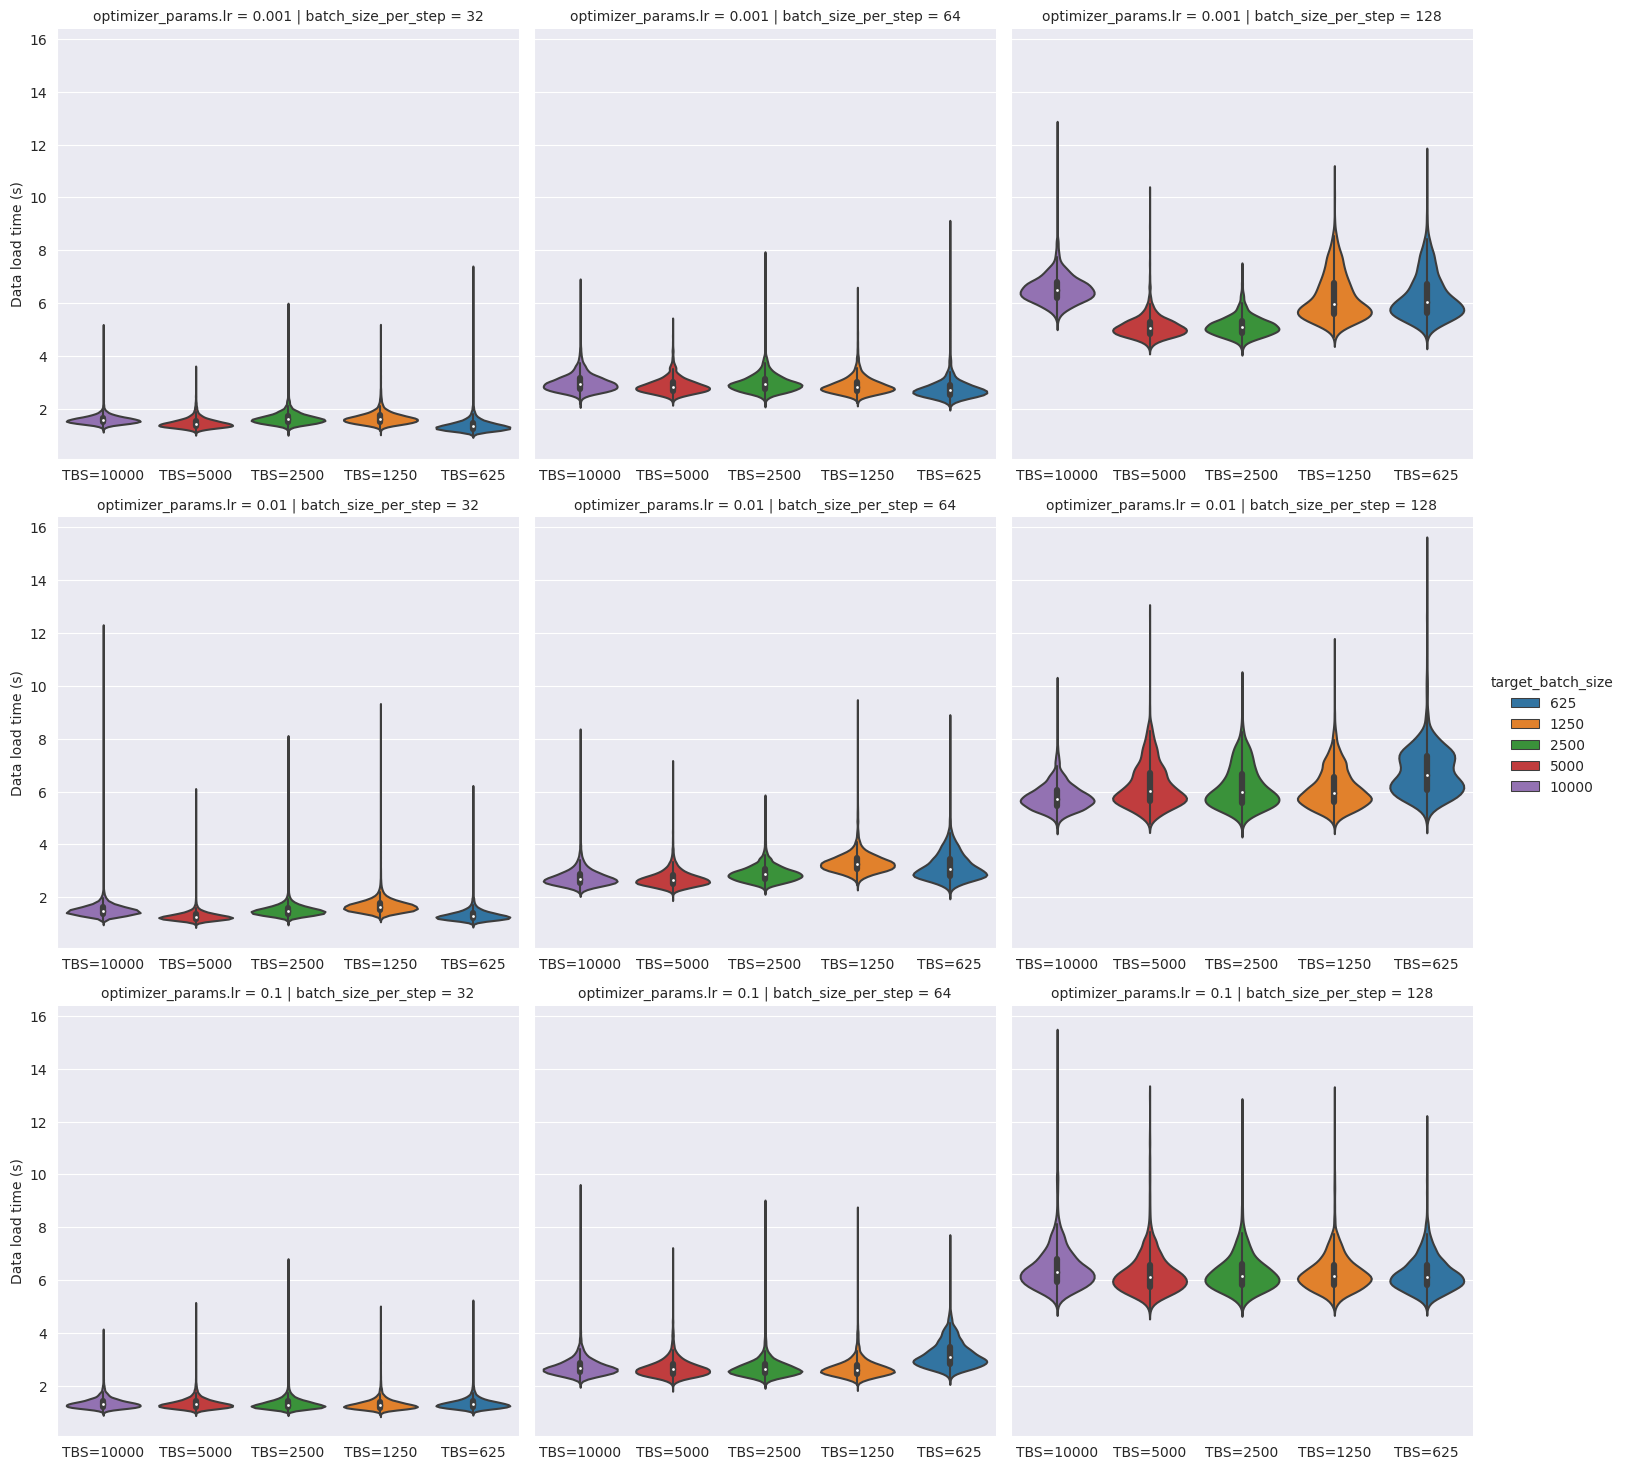

In [87]:
from viz import viz_column

viz_column("06", filename, "train/data_load_s", "", "Data load time (s)")

<Figure size 640x480 with 0 Axes>

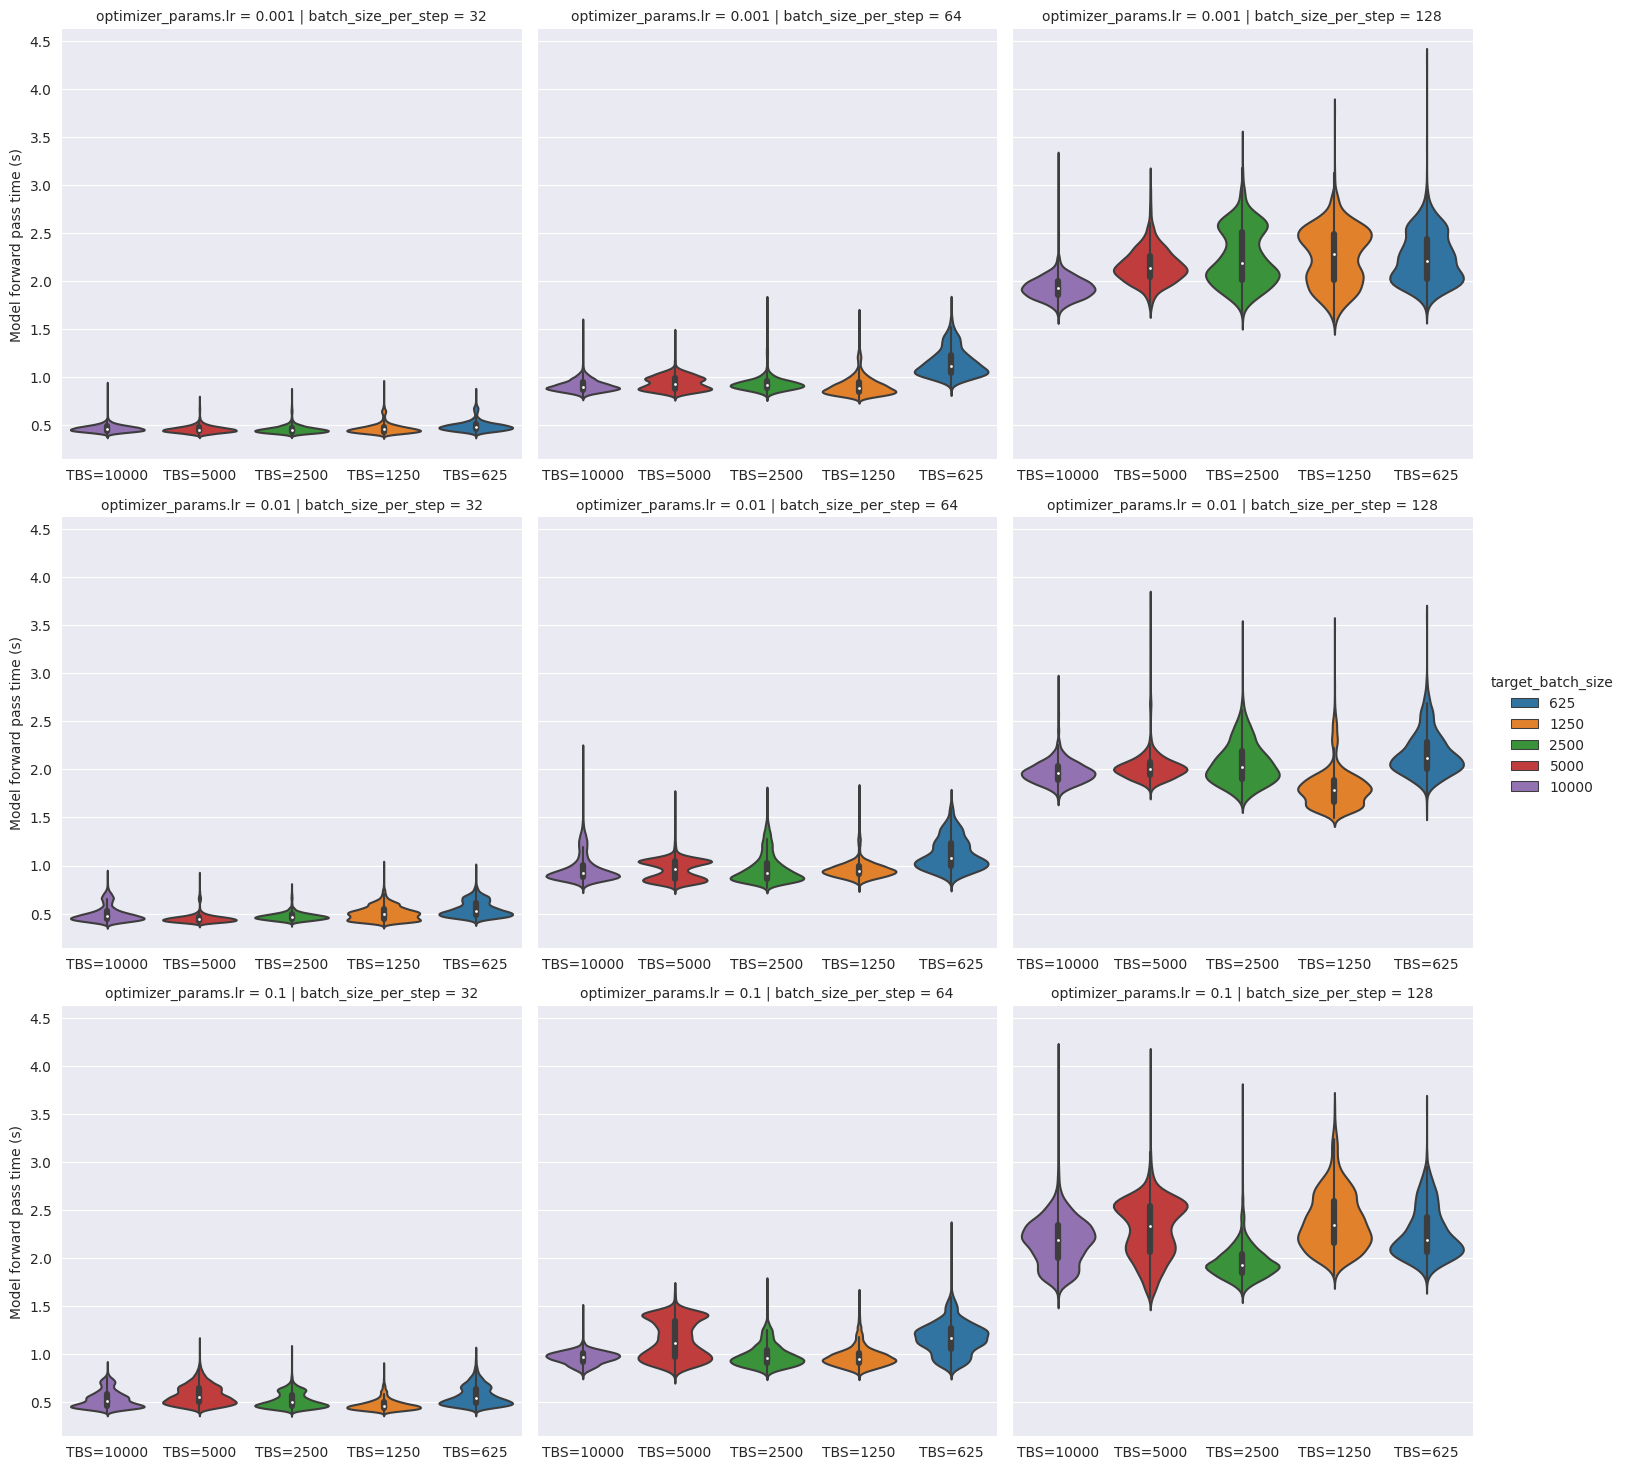

In [88]:
from viz import viz_column

viz_column("06", filename, "train/model_forward_s", "", "Model forward pass time (s)")

<Figure size 640x480 with 0 Axes>

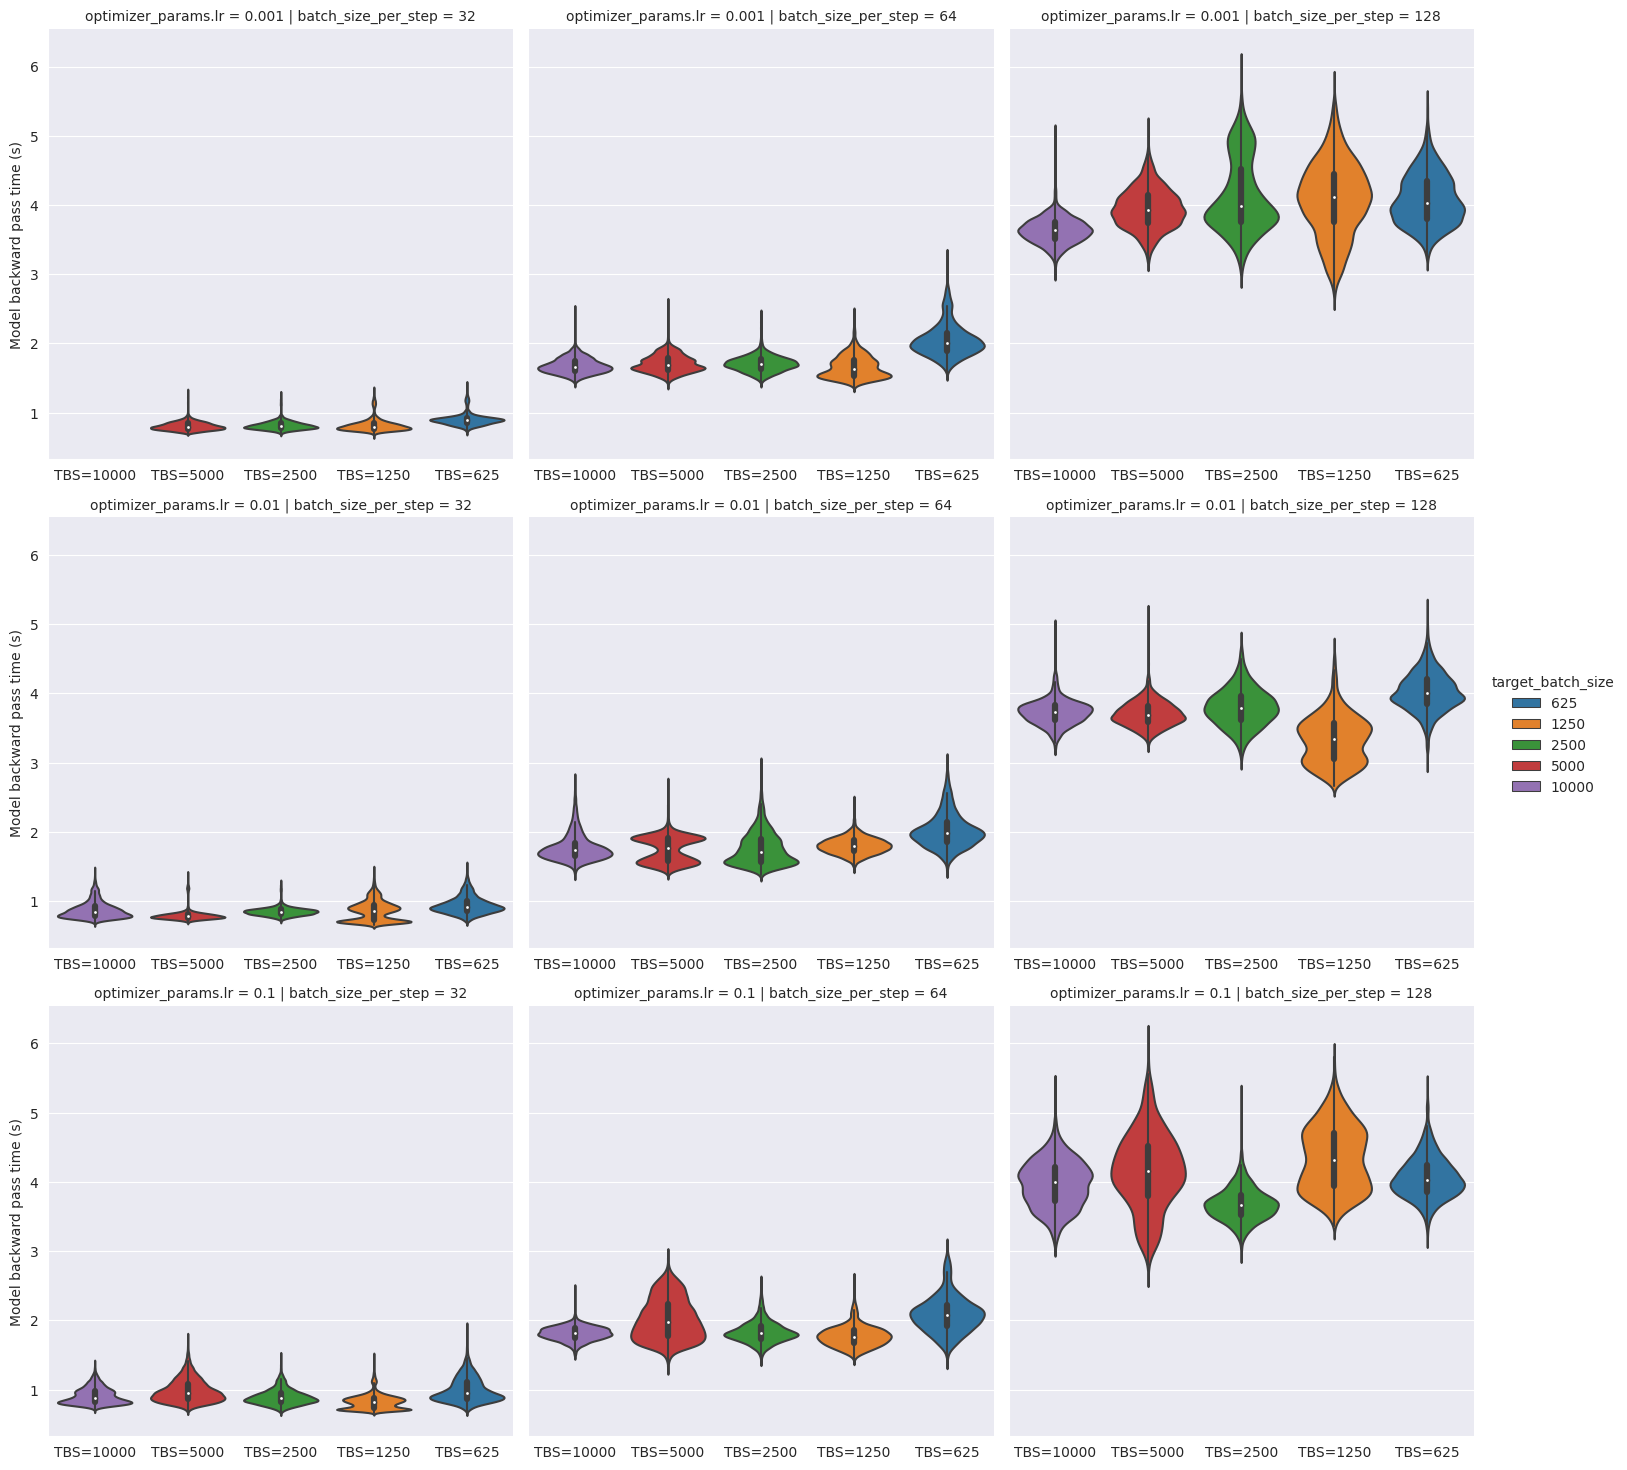

In [89]:
from viz import viz_column

viz_column("06", filename, "train/model_backward_only_s", "", "Model backward pass time (s)")

<Figure size 640x480 with 0 Axes>

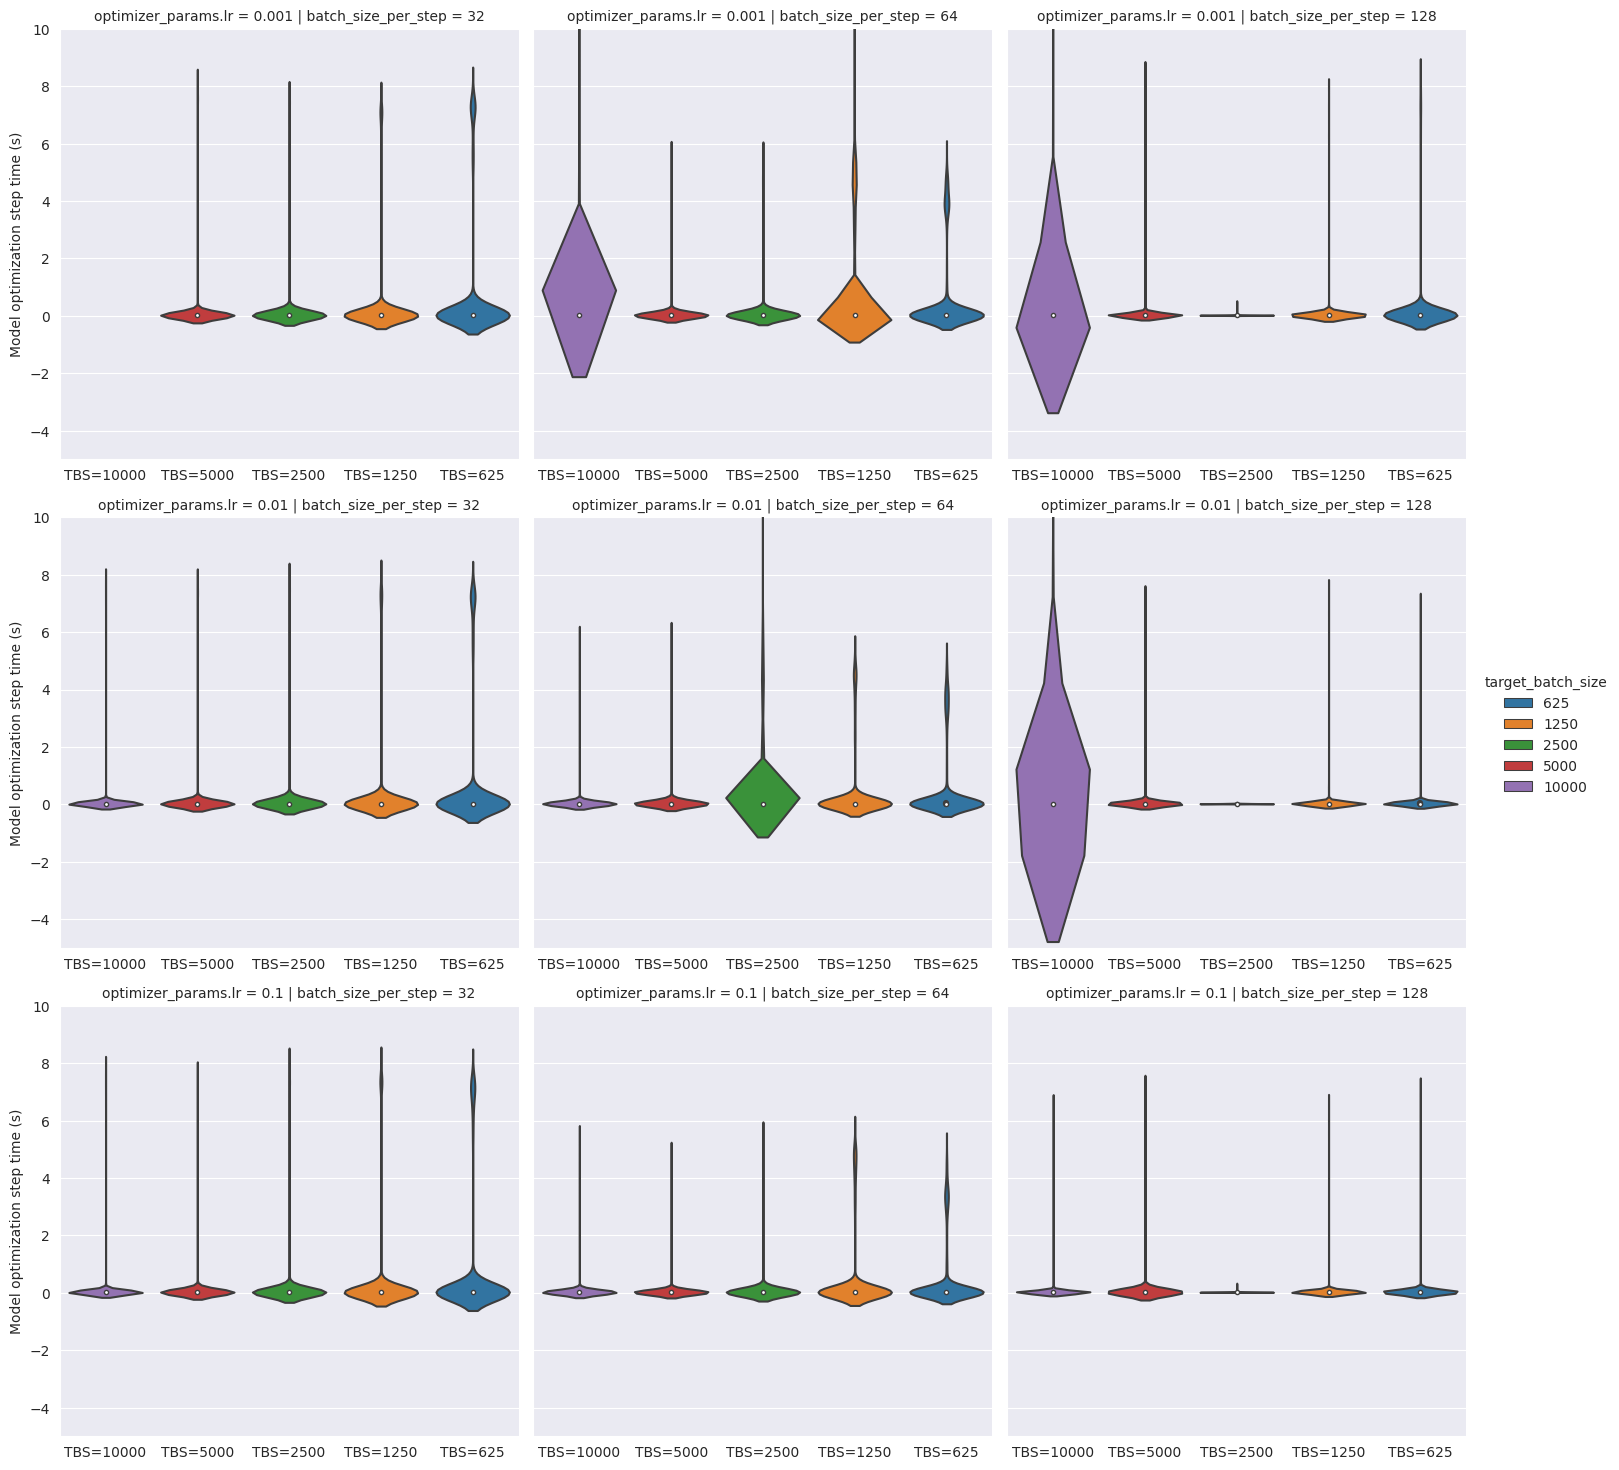

In [90]:
from viz import viz_column

viz_column("06", filename, "train/model_opt_s", "", "Model optimization step time (s)", ylim=(-5, 10))

<Figure size 640x480 with 0 Axes>

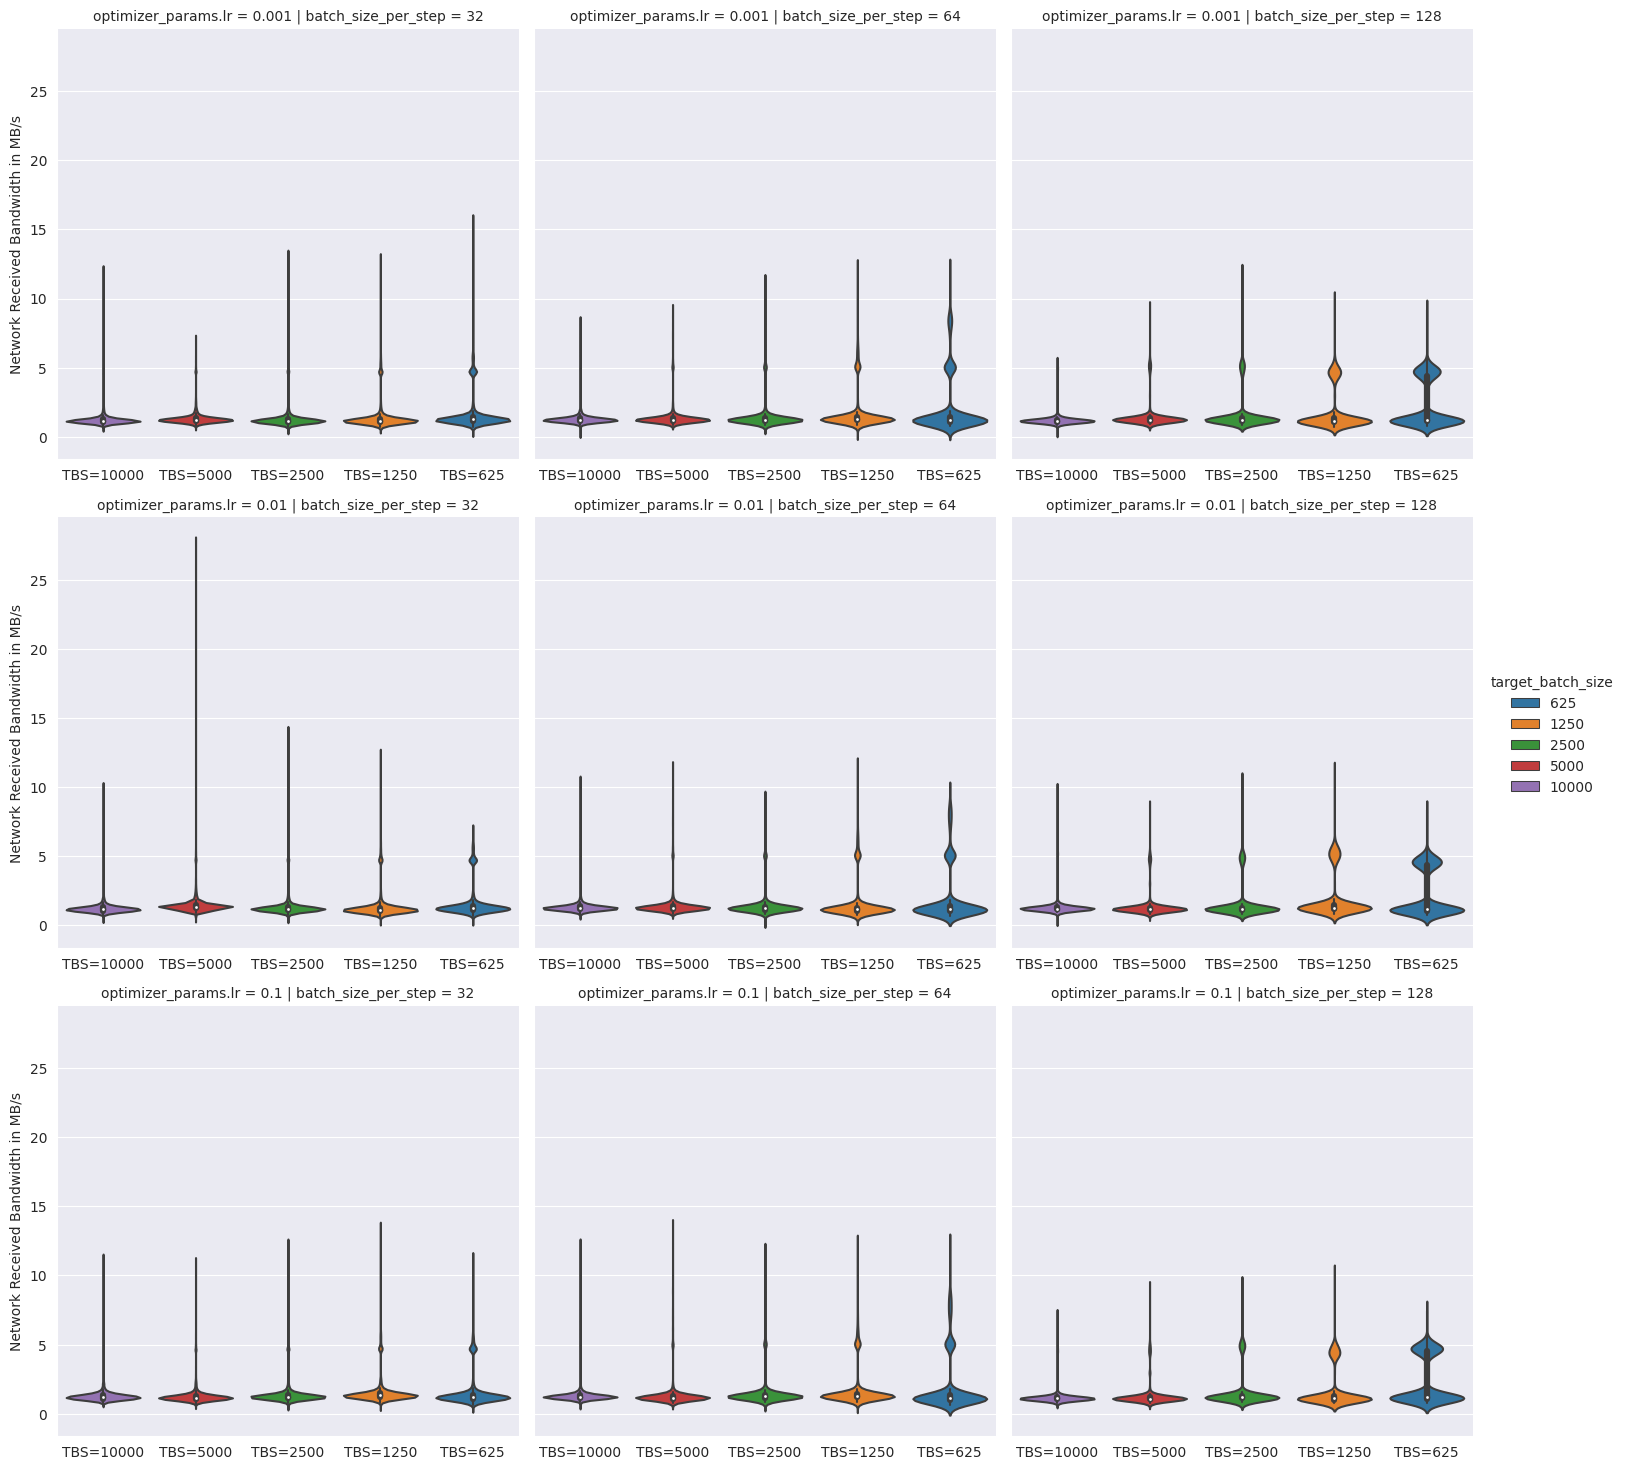

In [91]:
from viz import viz_column

viz_column("06", filename, "bandwidth/net_recv_sys_bandwidth_mbs", "", "Network Received Bandwidth in MB/s")

<Figure size 640x480 with 0 Axes>

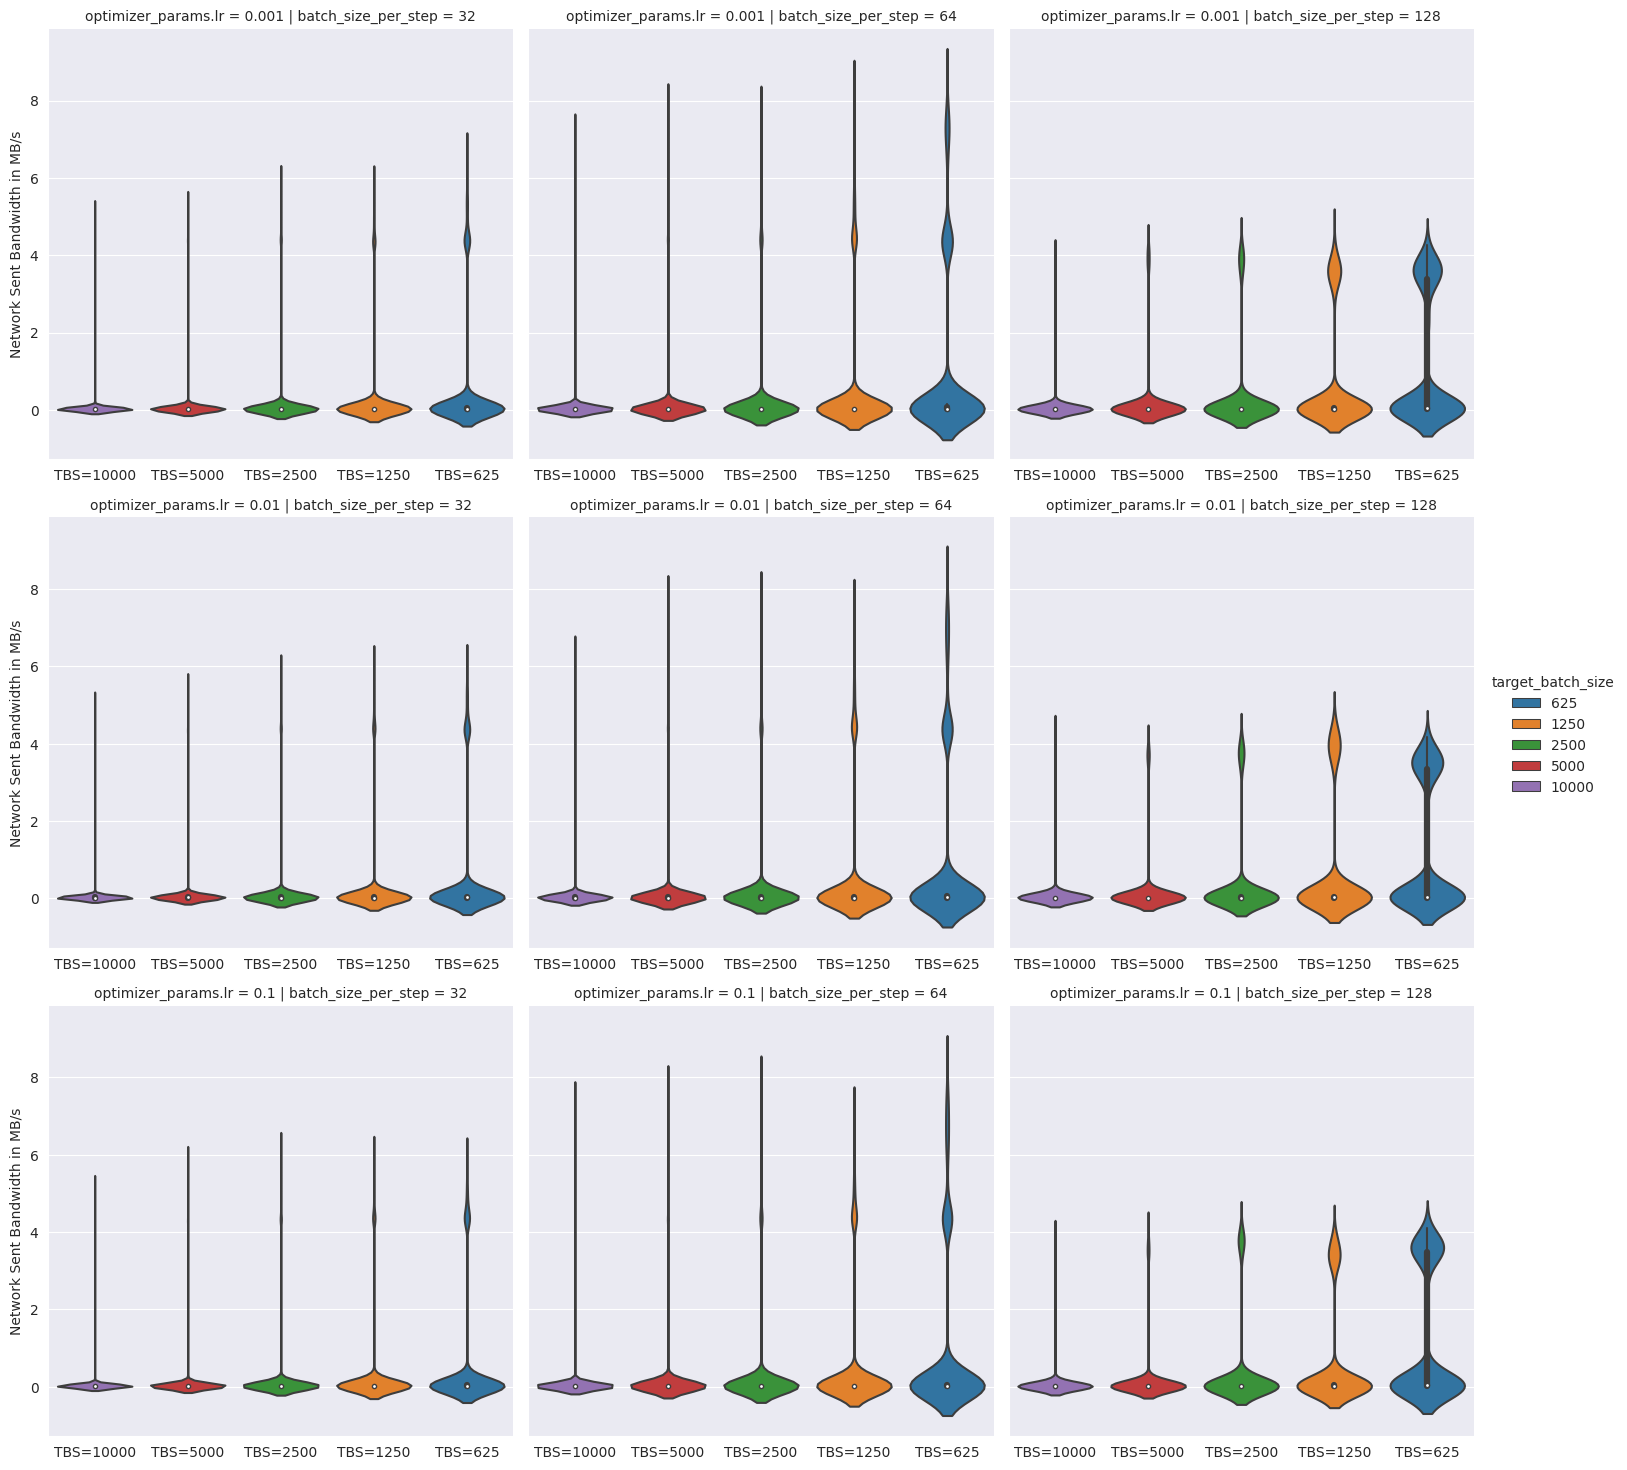

In [92]:
from viz import viz_column

viz_column("06", filename, "bandwidth/net_sent_sys_bandwidth_mbs", "", "Network Sent Bandwidth in MB/s")